In [8]:
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from collections import Counter
from tqdm import tqdm
import os

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilisation de: {DEVICE}\n")

Utilisation de: cuda



# PARTIE 1: CHARGEMENT DES DONNÉES

In [9]:
def load_data(train_path='../data/irishman/train.json', val_path='../data/irishman/validation.json'):
    """
    Charge les fichiers JSON d'entraînement et de validation.
    
    Explication:
    - On lit les fichiers JSON contenant les partitions en notation ABC
    - Chaque fichier contient une liste d'objets avec la clé 'abc notation'
    """
    with open(train_path, 'r', encoding='utf-8') as f:
        train_data = json.load(f)
    
    with open(val_path, 'r', encoding='utf-8') as f:
        val_data = json.load(f)
    
    print(f"Nombre de chansons d'entraînement: {len(train_data)}")
    print(f"Nombre de chansons de validation: {len(val_data)}")
    print(f"\nPremière chanson (extrait):")
    print(train_data[0]['abc notation'][:200])
    
    return train_data, val_data

In [10]:
print("=" * 50)
print("1. CHARGEMENT DES DONNÉES")
print("=" * 50)
train_data, val_data = load_data()

1. CHARGEMENT DES DONNÉES
Nombre de chansons d'entraînement: 214122
Nombre de chansons de validation: 2162

Première chanson (extrait):
X:1
L:1/8
M:4/4
K:Emin
|: E2 EF E2 EF | DEFG AFDF | E2 EF E2 B2 |1 efe^d e2 e2 :|2 efe^d e3 B |: e2 ef g2 fe | 
 defg afdf |1 e2 ef g2 fe | efe^d e3 B :|2 g2 bg f2 af | efe^d e2 e2 ||


# PARTIE 2: PRÉTRAITEMENT DES DONNÉES

In [11]:
def extract_unique_chars(data):
    """
    Étape 1: Extraction des caractères uniques
    
    Explication:
    - On parcourt toutes les chansons et collecte tous les caractères
    - On utilise un set pour garder uniquement les caractères uniques
    - Cela nous donne le vocabulaire complet du dataset
    """
    all_chars = set()
    for song in data:
        all_chars.update(song['abc notation'])
    
    # On trie pour avoir un ordre déterministe
    unique_chars = sorted(list(all_chars))
    
    print(f"Nombre de caractères uniques: {len(unique_chars)}")
    print(f"Caractères: {unique_chars[:20]}...")  # Affiche les 20 premiers
    
    return unique_chars


def create_mappings(unique_chars):
    """
    Étape 2: Mapping caractères-index
    
    Explication:
    - char_to_idx: dictionnaire pour convertir caractère -> index
    - idx_to_char: liste pour convertir index -> caractère
    - Ces mappings sont essentiels car les réseaux de neurones travaillent avec des nombres
    """
    char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
    idx_to_char = unique_chars
    
    print(f"Exemple de mapping: '{unique_chars[0]}' -> {char_to_idx[unique_chars[0]]}")
    
    return char_to_idx, idx_to_char


def vectorize_string(text, char_to_idx):
    """
    Étape 3: Vectorisation des chaînes
    
    Explication:
    - Convertit une chaîne de caractères en liste d'indices
    - Chaque caractère est remplacé par son index dans le vocabulaire
    - Exemple: "ABC" -> [0, 1, 2]
    """
    return [char_to_idx[char] for char in text]


def pad_or_truncate(text, max_length):
    """
    Étape 4: Padding des séquences
    
    Explication:
    - Toutes les séquences doivent avoir la même longueur pour former des batches
    - Si trop courte: on ajoute des espaces à la fin (padding)
    - Si trop longue: on coupe la fin (truncate)
    """
    if len(text) < max_length:
        # Padding: ajoute des espaces
        return text + ' ' * (max_length - len(text))
    else:
        # Truncate: coupe à la bonne longueur
        return text[:max_length]


def find_max_length(data):
    """
    Trouve la longueur maximale des chansons dans le dataset
    """
    max_len = max(len(song['abc notation']) for song in data)
    print(f"Longueur maximale: {max_len}")
    return max_len


def preprocess_data(data, char_to_idx, max_length):
    """
    Fonction complète de prétraitement
    
    Explication:
    - Applique le padding/truncate puis la vectorisation
    - Retourne une liste de séquences numériques prêtes pour l'entraînement
    """
    processed = []
    for song in data:
        text = pad_or_truncate(song['abc notation'], max_length)
        vectorized = vectorize_string(text, char_to_idx)
        processed.append(vectorized)
    
    return torch.tensor(processed, dtype=torch.long)

On cherche la longueur optimal pour les vecteurs 

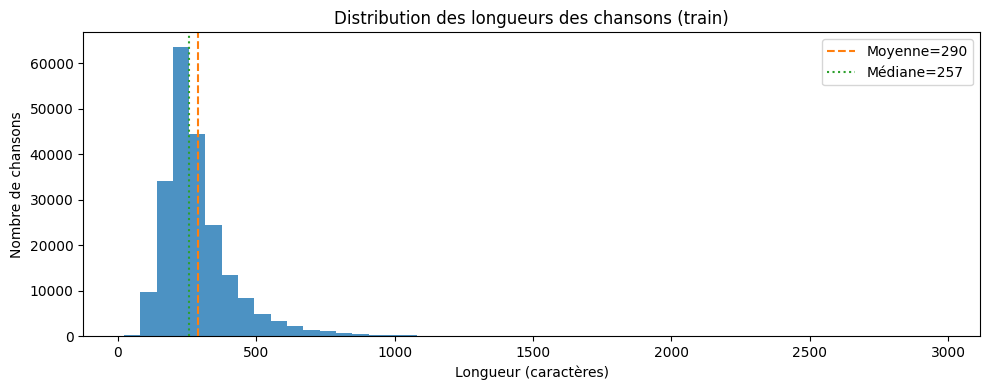

Min: 22, Max: 2968, Moyenne: 290.1, Médiane: 257.0


In [ ]:
import matplotlib.pyplot as plt

# Calcul des longueurs
lengths = [len(song['abc notation']) for song in train_data]

# Histogramme
plt.figure(figsize=(10,4))
plt.hist(lengths, bins=50, color='C0', alpha=0.8)
plt.axvline(np.mean(lengths), color='C1', linestyle='--', label=f'Moyenne={np.mean(lengths):.0f}')
plt.axvline(np.median(lengths), color='C2', linestyle=':', label=f'Médiane={np.median(lengths):.0f}')
plt.title("Distribution des longueurs des chansons (train)")
plt.xlabel("Longueur (caractères)")
plt.ylabel("Nombre de chansons")
plt.legend()
plt.tight_layout()
plt.show()

# Quelques statistiques rapides
print(f"Min: {min(lengths)}, Max: {max(lengths)}, Moyenne: {np.mean(lengths):.1f}, Médiane: {np.median(lengths)}")

La plus part du dataset est du longueur moins de 500, on choisi donc 500.

In [12]:
print("\n" + "=" * 50)
print("2. PRÉTRAITEMENT")
print("=" * 50)
unique_chars = extract_unique_chars(train_data)
char_to_idx, idx_to_char = create_mappings(unique_chars)
# max_length = find_max_length(train_data)
max_length = 500  # On fixe une longueur maximale pour simplifier


2. PRÉTRAITEMENT
Nombre de caractères uniques: 95
Caractères: ['\n', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3']...
Exemple de mapping: '
' -> 0


In [17]:
# Vectoriser
print("\nVectorisation des données...")
train_vectors = preprocess_data(train_data, char_to_idx, max_length)
val_vectors = preprocess_data(val_data, char_to_idx, max_length)
print(f"Shape train: {train_vectors.shape}")
print(f"Shape val: {val_vectors.shape}")


Vectorisation des données...


Shape train: torch.Size([214122, 500])
Shape val: torch.Size([2162, 500])


# PARTIE 3: DATASET PYTORCH

In [18]:
class MusicDataset(Dataset):
    """
    Dataset PyTorch pour les séquences musicales
    
    Explication du décalage input/target:
    - Input: tous les caractères sauf le dernier [:-1]
    - Target: tous les caractères sauf le premier [1:]
    - Exemple: "ABCD" -> input="ABC", target="BCD"
    - Le modèle apprend ainsi à prédire le prochain caractère
    """
    
    def __init__(self, data):
        """
        Args:
            data: tensor de shape (num_songs, seq_length)
        """
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        # Input: tout sauf le dernier élément
        x = sequence[:-1]
        # Target: tout sauf le premier élément (décalé de 1)
        y = sequence[1:]
        return x, y

In [19]:
BATCH_SIZE = 256

print("\n" + "=" * 50)
print("3. CRÉATION DES DATASETS")
print("=" * 50)
train_dataset = MusicDataset(train_vectors)
val_dataset = MusicDataset(val_vectors)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Vérifier un batch
x_sample, y_sample = next(iter(train_loader))
print(f"Batch input shape: {x_sample.shape}")
print(f"Batch target shape: {y_sample.shape}")


3. CRÉATION DES DATASETS
Batch input shape: torch.Size([256, 499])
Batch target shape: torch.Size([256, 499])


# PARTIE 4: MODÈLE LSTM

In [20]:
class MusicRNN(nn.Module):
    """
    Modèle LSTM pour la génération de musique
    
    Architecture:
    1. Embedding: convertit les indices en vecteurs denses
    2. LSTM: traite les séquences et capture les dépendances temporelles
    3. Linear: projette les sorties LSTM vers le vocabulaire
    
    Pourquoi cette architecture?
    - Embedding: donne une représentation continue riche des caractères
    - LSTM: capture les patterns temporels dans les séquences musicales
    - Linear: produit une distribution de probabilité sur le vocabulaire
    """
    
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(MusicRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Couche d'embedding: vocab_size -> embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM: traite les séquences
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        
        # Couche de sortie: hidden_size -> vocab_size
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        """
        Forward pass
        
        Args:
            x: input indices de shape (batch, seq_len)
            hidden: état caché du LSTM (optionnel)
        
        Returns:
            output: logits de shape (batch, seq_len, vocab_size)
            hidden: nouvel état caché
        """
        # Embedding: (batch, seq_len) -> (batch, seq_len, embedding_dim)
        embedded = self.embedding(x)
        
        # LSTM: (batch, seq_len, embedding_dim) -> (batch, seq_len, hidden_size)
        if hidden is not None:
            lstm_out, hidden = self.lstm(embedded, hidden)
        else:
            lstm_out, hidden = self.lstm(embedded)
        
        # Linear: (batch, seq_len, hidden_size) -> (batch, seq_len, vocab_size)
        output = self.fc(lstm_out)
        
        return output, hidden

In [22]:
EMBEDDING_DIM = 256
HIDDEN_SIZE = 1024

print("\n" + "=" * 50)
print("4. CRÉATION DU MODÈLE")
print("=" * 50)
vocab_size = len(unique_chars)
model = MusicRNN(vocab_size, EMBEDDING_DIM, HIDDEN_SIZE)
print(f"Nombre de paramètres: {sum(p.numel() for p in model.parameters()):,}")


4. CRÉATION DU MODÈLE
Nombre de paramètres: 5,372,767


# PARTIE 5: ENTRAÎNEMENT

In [ ]:
def calculate_accuracy(predictions, targets):
    """
    Calcule l'accuracy: pourcentage de caractères correctement prédits
    """
    pred_chars = predictions.argmax(dim=-1)
    correct = (pred_chars == targets).float()
    return correct.mean().item()


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, 
                device, save_path='best_model.pt', patience=5):
    """
    Boucle d'entraînement complète avec early stopping
    
    Explication:
    - Criterion: CrossEntropyLoss car c'est un problème de classification multi-classe
    - Optimizer: Adam pour l'optimisation adaptative
    - TensorBoard: pour visualiser l'entraînement
    - Early stopping: arrête si pas d'amélioration pendant 'patience' epochs
    
    Args:
        model: le modèle à entraîner
        train_loader: DataLoader d'entraînement
        val_loader: DataLoader de validation
        num_epochs: nombre d'époques
        learning_rate: taux d'apprentissage
        device: 'cuda' ou 'cpu'
        save_path: chemin pour sauvegarder le meilleur modèle
        patience: nombre d'époques sans amélioration avant early stopping
    """
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # TensorBoard pour le logging
    writer = SummaryWriter('runs/music_rnn')
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    print("Début de l'entraînement...")
    
    for epoch in range(num_epochs):
        # ===== PHASE D'ENTRAÎNEMENT =====
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch_idx, (x, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            x, y = x.to(device), y.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output, _ = model(x)
            
            # Reshape pour la loss
            # output: (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
            # y: (batch, seq_len) -> (batch*seq_len)
            loss = criterion(output.reshape(-1, output.size(-1)), y.reshape(-1))
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping pour stabiliser l'entraînement
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_accuracy(output, y)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        # ===== PHASE DE VALIDATION =====
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _ = model(x)
                loss = criterion(output.reshape(-1, output.size(-1)), y.reshape(-1))
                val_loss += loss.item()
                val_acc += calculate_accuracy(output, y)
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        # Logging
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
        
        # Early stopping et sauvegarde du meilleur modèle
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, save_path)
            print(f"✓ Meilleur modèle sauvegardé (val_loss: {val_loss:.4f})")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"\nEarly stopping après {epoch+1} époques")
                break
    
    writer.close()
    print("\nEntraînement terminé!")

In [12]:
LEARNING_RATE = 5e-3
NUM_EPOCHS = 3

print("\n" + "=" * 50)
print("5. ENTRAÎNEMENT")
print("=" * 50)
train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, DEVICE)


5. ENTRAÎNEMENT


Début de l'entraînement...


Epoch 1/3: 100%|██████████| 837/837 [10:22<00:00,  1.34it/s]


Epoch 1: Train Loss=1.0502, Train Acc=0.7467, Val Loss=0.5726, Val Acc=0.8154
✓ Meilleur modèle sauvegardé (val_loss: 0.5726)


Epoch 2/3: 100%|██████████| 837/837 [10:27<00:00,  1.33it/s]


Epoch 2: Train Loss=0.5423, Train Acc=0.8221, Val Loss=0.5236, Val Acc=0.8296
✓ Meilleur modèle sauvegardé (val_loss: 0.5236)


Epoch 3/3: 100%|██████████| 837/837 [10:28<00:00,  1.33it/s]


Epoch 3: Train Loss=0.5079, Train Acc=0.8328, Val Loss=0.4941, Val Acc=0.8388
✓ Meilleur modèle sauvegardé (val_loss: 0.4941)

Entraînement terminé!


# PARTIE 6: GÉNÉRATION DE MUSIQUE

In [24]:
def generate_music(model, start_sequence, char_to_idx, idx_to_char, 
                   length=200, device='cpu', temperature=1.0):
    """
    Génère une séquence musicale avec le modèle entraîné
    
    Explication:
    - On commence avec une séquence de départ
    - À chaque étape, on prédit le prochain caractère
    - On ajoute ce caractère à la séquence et on continue
    - Temperature contrôle la randomness:
      * temperature < 1: plus conservateur (prédit les caractères les plus probables)
      * temperature = 1: utilise les probabilités telles quelles
      * temperature > 1: plus créatif (ajoute plus de randomness)
    
    Args:
        model: modèle entraîné
        start_sequence: chaîne de départ
        char_to_idx: mapping caractère -> index
        idx_to_char: mapping index -> caractère
        length: longueur de la séquence à générer
        device: 'cuda' ou 'cpu'
        temperature: contrôle la randomness (>0)
    
    Returns:
        generated: chaîne générée
    """
    model.eval()
    model = model.to(device)
    
    # Convertir la séquence de départ en indices
    current_sequence = [char_to_idx[c] for c in start_sequence]
    generated = start_sequence
    
    with torch.no_grad():
        hidden = None
        
        for _ in range(length):
            # Préparer l'input
            x = torch.tensor([current_sequence], dtype=torch.long).to(device)
            
            # Prédiction
            output, hidden = model(x, hidden)
            
            # Prendre la dernière prédiction
            logits = output[0, -1, :] / temperature
            
            # Appliquer softmax pour obtenir des probabilités
            probs = torch.softmax(logits, dim=0)
            
            # Échantillonner le prochain caractère
            next_idx = torch.multinomial(probs, 1).item()
            
            # Ajouter à la séquence
            current_sequence.append(next_idx)
            generated += idx_to_char[next_idx]
            
            # Garder seulement les derniers caractères pour l'état
            # (optionnel, pour la mémoire)
            if len(current_sequence) > 100:
                current_sequence = current_sequence[-100:]
    
    return generated

In [25]:
print("\n" + "=" * 50)
print("6. GÉNÉRATION DE MUSIQUE")
print("=" * 50)

# Charger le meilleur modèle
checkpoint = torch.load('best_model.pt', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])

# Générer avec différentes séquences de départ
start_sequences = [
    "X:1\nT:",  # Début typique d'une partition ABC
    "M:4/4\nK:G\n",  # Métrique et tonalité
]

for start in start_sequences:
    print(f"\nSéquence de départ: {repr(start)}")
    generated = generate_music(model, start, char_to_idx, idx_to_char, 
                                length=200, device=DEVICE, temperature=0.8)
    print(f"Musique générée:\n{generated}\n")
    print("-" * 50)


6. GÉNÉRATION DE MUSIQUE

Séquence de départ: 'X:1\nT:'


Musique générée:
X:1
T:9/8{K:G
"^A" B2 D GBd | f2 e dcB | A2 G FGA | B2 B g2 d | B2 g g2 z | B2 e def | 
 g2 z z2 D | G2 g gdB | A2 B c2 z | D2 D G2 B | E2 G F2 G | A2 G F2 z | G2 A G2 F ||                                  

--------------------------------------------------

Séquence de départ: 'M:4/4\nK:G\n'
Musique générée:
M:4/4
K:G
 (3DEF | G2G2 AcBA GFGA B2G2 | A2AG FGAF D4 D2 :: de | f2>e2 dcBA B2<G2 B2 | 
 A2>Bc d2c2 BcBA GABc | d2>e2 f2>e2 e2>d2 c2A2 | B2A2 A2 z2 z2 A2 :|                                                      

--------------------------------------------------
